<a href="https://colab.research.google.com/github/hsuanchia/PTT-Gossiping-Chatbot/blob/main/gossip_chatbot_train_char.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! nvidia-smi

Tue Jun 22 05:48:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json,pickle
import numpy as np
import tensorflow as tf
from keras.layers import Input,Dropout,Embedding,LSTM,Dense,TimeDistributed
from keras.models import Model,load_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
from tqdm import tqdm

# Import Data

In [ ]:
q_path = '/content/drive/MyDrive/NLP/2021May_GossipingQA_question.json'
a_path = '/content/drive/MyDrive/NLP/2021May_GossipingQA_answer.json'
file_q = open(q_path,'r',encoding='utf8')
q_data = json.load(file_q)
file_a = open(a_path,'r',encoding='utf8')
a_data = json.load(file_a)

In [ ]:
q_data = np.array(q_data)
a_data = np.array(a_data)
q_data, a_data = shuffle(q_data,a_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
q, a = [], []
for i in range(len(q_data)):
  seq_q, seq_a = q_data[i][0], a_data[i][0]
  q.append("".join(seq_q))
  a.append("".join(seq_a))

# Tokenizer

In [ ]:
token = Tokenizer(char_level=True,filters='',oov_token='<unk>')
token.fit_on_texts(q)
token.fit_on_texts(a)

In [ ]:
print(len(token.word_index))
word_index = token.word_index
index_word = token.index_word

4762


# Parameter Initialization

In [ ]:
start = '<sos>'
end = '<end>' 
unk = '<unk>'
pad = '<pad>'

In [ ]:
word_index[start] = 4762
word_index[end] = 4763
index_word[4762] = start
index_word[4763] = end

Q_max_length = 42 #q_data max = 42, a_data max char = 70
A_max_length = 70
voc_size = len(word_index)
embedding_dim = 300
unit = 512

In [ ]:
pickle.dump(obj=index_word, file=open(f'/content/drive/MyDrive/NLP/char_index_word.pkl', 'wb'))
pickle.dump(obj=word_index, file=open(f'/content/drive/MyDrive/NLP/char_word_index.pkl', 'wb'))

In [ ]:
pickle.dump(obj=token,file=open(f'/content/drive/MyDrive/NLP/char_token.pkl', 'wb'))

# Data Preprocessing

In [ ]:
def fit_sentence(seq,word2index,max_length):
    out_seq = token.texts_to_sequences(seq)
    tmp = [[word_index[start]]]
    tmp.extend(out_seq)
    tmp.append([word_index[end]])
    out_seq = tmp
    out_seq = pad_sequences([out_seq],maxlen=max_length,padding='post')
    out_seq = np.squeeze(out_seq)
    return out_seq

In [ ]:
s = fit_sentence('請問有沒有疫苗的掛?',word_index,Q_max_length)
print(s)

[4762  230   89    8   17    8   28   61    3  583    9 4763    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [ ]:
# 如果只是想測試inference 從這裡往前的所有code都跑過就可以直接跳到後面inference
def Q_data_generator(data,word2index,max_length):
  out = []
  for i in tqdm(data):
    out_seq = token.texts_to_sequences(i)
    tmp = [[word_index[start]]]
    tmp.extend(out_seq)
    tmp.append([word_index[end]])
    out_seq = tmp
    out_seq = pad_sequences([out_seq],maxlen=max_length,padding='post')
    out.append(out_seq)
  return np.array(out)

In [ ]:
def A_data_generator(data,word2index,max_length):
  out1, out2 = [], []
  for i in tqdm(data):
    seq = token.texts_to_sequences(i)
    tmp = [[word_index[start]]]
    tmp.extend(seq)
    tmp.append([word_index[end]])
    seq = tmp
    seq1, seq2 = seq[:-1], seq[1:]
    o1 = pad_sequences([seq1],maxlen=max_length,padding='post')
    o2 = pad_sequences([seq2],maxlen=max_length,padding='post')
    out1.append(o1)
    out2.append(o2)
  return np.array(out1), np.array(out2)

In [ ]:
# 處理question
Q = Q_data_generator(q,word_index,Q_max_length)

100%|██████████| 48560/48560 [00:04<00:00, 11962.93it/s]


In [ ]:
# 處理answer
# ex: 原本的答案假設是[1,2,3,4,5,6]
# A1 = [1,2,3,4,5]; A2 = [2,3,4,5,6]
A1, A2 = A_data_generator(a,word_index,A_max_length) 

100%|██████████| 48560/48560 [00:08<00:00, 5784.51it/s]


In [ ]:
# 將資料降維: (None,1,max_length) -> (None,max_length)
Q = np.squeeze(Q)
A1 = np.squeeze(A1)
A2 = np.squeeze(A2)

In [ ]:
# 分割資料
q_train,q_val = Q[:40000],Q[40000:]
a1_train,a1_val = A1[:40000],A1[40000:]
a2_train,a2_val = A2[:40000],A2[40000:]
print('Train: ', len(q_train))
print('Validation: ', len(q_val))

Train:  40000
Validation:  8560


In [ ]:
print(q_train[0])
print(a1_train[0])
print(a2_train[0])

[4762    8  286  288   43   25   17  164  507  341    2   40   15  159
 4763    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
[4762    2   27  156   20    5   21   51  104    2   18   45   11    2
   20    4  446   29  122  630    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
[   2   27  156   20    5   21   51  104    2   18   45   11    2   20
    4  446   29  122  630 4763    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


# Model

Model: "Gossip_ChatBot"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Q_input (InputLayer)            [(None, 42)]         0                                            
__________________________________________________________________________________________________
A_input (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
Q_emb (Embedding)               (None, 42, 300)      1429500     Q_input[0][0]                    
__________________________________________________________________________________________________
A_emb (Embedding)               (None, 70, 300)      1429500     A_input[0][0]                    
_____________________________________________________________________________________

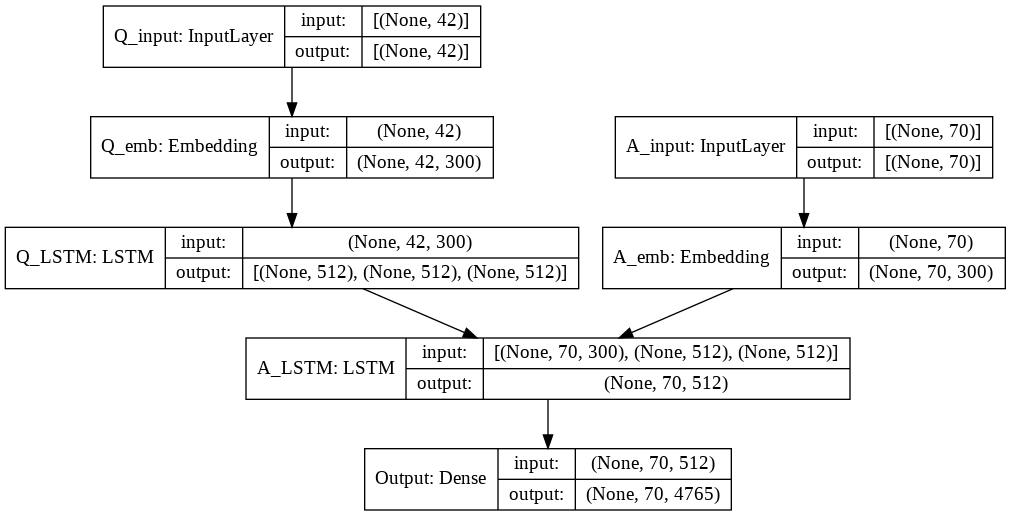

In [ ]:
Q_in = Input((Q_max_length,),name='Q_input')
Q_emb = Embedding(voc_size+1,embedding_dim,mask_zero=True,name='Q_emb')(Q_in)
Q_out, Q_h, Q_c = LSTM(unit,return_state=True,recurrent_dropout=0.25,name='Q_LSTM')(Q_emb)
Q_state = [Q_h,Q_c]
A_in = Input((A_max_length,),name='A_input')
A_emb = Embedding(voc_size+1,embedding_dim,mask_zero=True,name='A_emb')(A_in)
A_out = LSTM(unit,return_sequences=True,recurrent_dropout=0.25,dropout=0.5,name='A_LSTM')(A_emb,initial_state=Q_state)
output = Dense(voc_size+1,activation='softmax',name='Output')(A_out)

model = Model(inputs=[Q_in,A_in],outputs=output,name='Gossip_ChatBot')
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.summary()
model.compile(loss='sparse_categorical_crossentropy',optimizer=opt,metrics=['sparse_categorical_accuracy'])

tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
my_callbacks = [EarlyStopping(patience=5,monitor='val_loss')] 
model.fit((q_train,a1_train),a2_train,epochs=1000,validation_data=((q_val,a1_val),a2_val),callbacks=my_callbacks)

Epoch 1/1000
1250/1250 [==============================] - 317s 250ms/step - loss: 1.6696 - sparse_categorical_accuracy: 0.1670 - val_loss: 1.4069 - val_sparse_categorical_accuracy: 0.2392
Epoch 2/1000
1250/1250 [==============================] - 307s 246ms/step - loss: 1.3789 - sparse_categorical_accuracy: 0.2511 - val_loss: 1.3233 - val_sparse_categorical_accuracy: 0.2673
Epoch 3/1000
1250/1250 [==============================] - 308s 246ms/step - loss: 1.3025 - sparse_categorical_accuracy: 0.2720 - val_loss: 1.2861 - val_sparse_categorical_accuracy: 0.2796
Epoch 4/1000
1250/1250 [==============================] - 306s 245ms/step - loss: 1.2542 - sparse_categorical_accuracy: 0.2844 - val_loss: 1.2635 - val_sparse_categorical_accuracy: 0.2862
Epoch 5/1000
1250/1250 [==============================] - 310s 248ms/step - loss: 1.2181 - sparse_categorical_accuracy: 0.2940 - val_loss: 1.2497 - val_sparse_categorical_accuracy: 0.2927
Epoch 6/1000
1250/1250 [==============================] - 31

In [ ]:
model.save('/content/drive/MyDrive/NLP/Gossip_chatbot_char_7.h5')

# Inference 

In [ ]:
#跑下面inference前,要先改你要測試的model，否則就是前方訓練好的model
#也可以不跑前方訓練，那就是這裡要記得import model
model = load_model('/content/drive/MyDrive/NLP/Gossip_chatbot_char_6.h5')

In [ ]:
while True:
  question = input('公威阿: ')
  if question == '滾': # 輸入 '滾' 即可結束Chat Bot
    print('...88')
    break
  ans_seq = ''
  cur_token = start
  word_count = 1
  target_seq = np.zeros((1,A_max_length),dtype='int64')
  target_seq[0,0] = word_index[start]
  q = fit_sentence(question,word_index,Q_max_length)
  q = np.squeeze(q)
  q = tf.expand_dims(q,0)
  while word_count < A_max_length:
    decoder_output = model.predict([q,target_seq])
    ind = np.argmax(decoder_output[0,word_count])
    cur_token = index_word[ind]
    if cur_token == end:
      break
    ans_seq += cur_token
    target_seq[0,word_count] = ind
    word_count += 1
  print(ans_seq)

公威阿: 地震
                                                                     
公威阿: 遇到地震
 你是不是不會有人說你要投氧
公威阿: 有地震
                                                                     
公威阿: 趁亂告白
 我都不知道 我是不是我的
公威阿: 我沒割包皮
 我都不知道 我也想知道 我也想知道
公威阿: 地震黃金必男時間是幾秒
 我都不知道 我都不知道 我也想知道
公威阿: 地震黃金避難時間是多少
 我都不知道 我也不知道 我都不知道
公威阿: 3+11=?
 你是不是不知道                                                             
公威阿: fuck
 你是不是不知道 但是你的問題是你的問題
公威阿: 你會寫C語言ㄇ
 我都不知道 我都不知道 我是不是我的
公威阿: 我們都有覺悟 要瘋狂到日出
 你是不是不是在家裡的事 你是不是都不知道
公威阿: 已經有太多讓步
 你是不是說不懂?????????????????????????????????????????????????????????????
公威阿: 水電和房租
 我都不知道 我都不知道 我都不知道
公威阿: Let's go party party all night,
 你是不是不是說你的事 你是不是都不知道                                                 
公威阿: 每一分鐘就等於過了六十秒
 我都不知道 我也不知道 我都不知道 我都不知道
公威阿: 明天一定是翌日喔
 我都不知道 我也不知道 我都不知道 我都不知道
公威阿: 大家都有妹妹嗎
 我都不知道 我都不知道 我都不知道
公威阿: 妹妹
 你是不是都不知道                                                            
公威阿: CDC
 我們這邊都是要上班的人，不要太不滿
公威阿: 新冠肺炎
 你是不是不知道嗎？
公威阿: COVID-19
 我都不知道 我也想知道 我也想知道
公威阿: 口罩
 不是

KeyboardInterrupt: ignored